In [1]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

from torchvision import datasets
from torchvision import transforms

import time

import matplotlib.pyplot as plt
from PIL import Image


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [13]:
#ResNet101
# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.01
NUM_EPOCHS = 25

# Architecture
NUM_CLASSES = 10
BATCH_SIZE = 128
DEVICE = torch.device('cuda:0')
GRAYSCALE = False

In [5]:
train_indices = torch.arange(0, 49000)
valid_indices = torch.arange(49000, 50000)


train_and_valid = datasets.CIFAR10(root='data', 
                                   train=True, 
                                   transform=transforms.ToTensor(),
                                   download=True)

train_dataset = Subset(train_and_valid, train_indices)
valid_dataset = Subset(train_and_valid, valid_indices)


test_dataset = datasets.CIFAR10(root='data', 
                                train=False, 
                                transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE,
                          num_workers=8,
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE,
                          num_workers=8,
                          shuffle=False)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=8,
                         shuffle=False)


# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

for images, labels in test_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break
    
for images, labels in valid_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Files already downloaded and verified
Image batch dimensions: torch.Size([128, 3, 32, 32])
Image label dimensions: torch.Size([128])
Image batch dimensions: torch.Size([128, 3, 32, 32])
Image label dimensions: torch.Size([128])
Image batch dimensions: torch.Size([128, 3, 32, 32])
Image label dimensions: torch.Size([128])


In [6]:
#ResNet Model

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        #self.fc = nn.Linear(2048 * block.expansion, num_classes)
        self.fc = nn.Linear(2048, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        #x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet101(num_classes, grayscale):
    """Constructs a ResNet-101 model."""
    model = ResNet(block=Bottleneck, 
                   layers=[3, 4, 23, 3],
                   num_classes=NUM_CLASSES,
                   grayscale=grayscale)
    return model

In [10]:
torch.manual_seed(RANDOM_SEED)

model = resnet101(NUM_CLASSES, GRAYSCALE)
model.to("cuda:0")
 
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

In [15]:
#training 
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

start_time = time.time()
cost_ac = []
train_ac = []
val_ac = []
# use random seed for reproducibility (here batch shuffling)
torch.manual_seed(RANDOM_SEED)

for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    for batch_idx, (features, targets) in enumerate(train_loader):
    
        ### PREPARE MINIBATCH
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        cost_ac.append(cost.item())
        ### LOGGING
        if not batch_idx % 120:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')
    

    # no need to build the computation graph for backprop when computing accuracy
    with torch.set_grad_enabled(False):
        train_acc = compute_accuracy(model, train_loader, device=DEVICE)
        valid_acc = compute_accuracy(model, valid_loader, device=DEVICE)
        train_ac.append(train_acc.item())
        val_ac.append(valid_acc.item())
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Acc.: {train_acc:.2f}%'
              f' | Validation Acc.: {valid_acc:.2f}%')
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/025 | Batch 000/383 | Cost: 1.2319
Epoch: 001/025 | Batch 120/383 | Cost: 1.1645
Epoch: 001/025 | Batch 240/383 | Cost: 1.0411
Epoch: 001/025 | Batch 360/383 | Cost: 1.3722
Epoch: 001/025 Train Acc.: 56.41% | Validation Acc.: 57.70%
Time elapsed: 5.24 min
Epoch: 002/025 | Batch 000/383 | Cost: 1.2286
Epoch: 002/025 | Batch 120/383 | Cost: 1.0302
Epoch: 002/025 | Batch 240/383 | Cost: 1.4211
Epoch: 002/025 | Batch 360/383 | Cost: 1.2559
Epoch: 002/025 Train Acc.: 55.32% | Validation Acc.: 55.40%
Time elapsed: 10.17 min
Epoch: 003/025 | Batch 000/383 | Cost: 1.1725
Epoch: 003/025 | Batch 120/383 | Cost: 1.1872
Epoch: 003/025 | Batch 240/383 | Cost: 1.5335
Epoch: 003/025 | Batch 360/383 | Cost: 1.3562
Epoch: 003/025 Train Acc.: 61.64% | Validation Acc.: 60.20%
Time elapsed: 15.09 min
Epoch: 004/025 | Batch 000/383 | Cost: 0.8545
Epoch: 004/025 | Batch 120/383 | Cost: 1.1758
Epoch: 004/025 | Batch 240/383 | Cost: 1.0509
Epoch: 004/025 | Batch 360/383 | Cost: 0.9360
Epoch: 004/02

In [18]:
#ResNet101 Evaluation
with torch.set_grad_enabled(False):
    test_accuracy = compute_accuracy(model=model,
                           data_loader=test_loader,
                           device=DEVICE)
  
print(f'Test ACC: {test_accuracy:.2f}%')

Test ACC: 75.26%


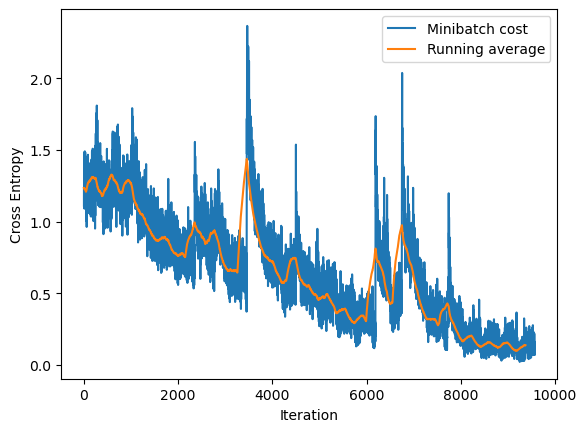

In [24]:
plt.plot(cost_ac, label='Minibatch cost')
plt.plot(np.convolve(cost_ac, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

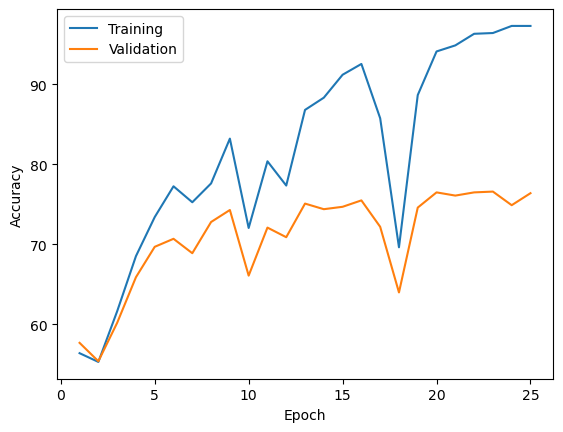

In [26]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_ac, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), val_ac, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [27]:
#DesNet121 Model

import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from collections import OrderedDict



def _bn_function_factory(norm, relu, conv):
    def bn_function(*inputs):
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = conv(relu(norm(concated_features)))
        return bottleneck_output

    return bn_function


class _DenseLayer(nn.Sequential):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate, memory_efficient=False):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1,
                                           bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False)),
        self.drop_rate = drop_rate
        self.memory_efficient = memory_efficient

    def forward(self, *prev_features):
        bn_function = _bn_function_factory(self.norm1, self.relu1, self.conv1)
        if self.memory_efficient and any(prev_feature.requires_grad for prev_feature in prev_features):
            bottleneck_output = cp.checkpoint(bn_function, *prev_features)
        else:
            bottleneck_output = bn_function(*prev_features)
        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return new_features


class _DenseBlock(nn.Module):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, memory_efficient=False):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.named_children():
            new_features = layer(*features)
            features.append(new_features)
        return torch.cat(features, 1)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))


class DenseNet121(nn.Module):

    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_featuremaps=64, bn_size=4, drop_rate=0, num_classes=1000, memory_efficient=False,
                 grayscale=False):

        super(DenseNet121, self).__init__()

        # First convolution
        if grayscale:
            in_channels=1
        else:
            in_channels=3
        
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(in_channels=in_channels, out_channels=num_init_featuremaps,
                                kernel_size=7, stride=2,
                                padding=3, bias=False)), # bias is redundant when using batchnorm
            ('norm0', nn.BatchNorm2d(num_features=num_init_featuremaps)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_featuremaps
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        logits = self.classifier(out)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [53]:
torch.manual_seed(RANDOM_SEED)

modelb = DenseNet121(num_classes=NUM_CLASSES, grayscale=GRAYSCALE)
modelb.to(DEVICE)

optimizerb = torch.optim.Adam(modelb.parameters(), lr=LEARNING_RATE)  

In [38]:
#training and logging desnet121

cost_list = []
train_acc_list, valid_acc_list = [], []


for epoch in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (featuresd, targetsd) in enumerate(train_loader):
        
        featuresd = featuresd.to(DEVICE)
        targetsd = targetsd.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logitsb, probasb = modelb(featuresb)
        costb = F.cross_entropy(logitsb, targetsb)
        optimizerb.zero_grad()
        
        costb.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizerb.step()
        
        cost_list.append(costb.item())
        if not batch_idx % 150:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {costb:.4f}')

        

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        
        train_accb = compute_accuracy(modelb, train_loader, device=DEVICE)
        valid_accb = compute_accuracy(modelb, valid_loader, device=DEVICE)
        
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d}\n'
              f'Train ACC: {train_accb:.2f} | Validation ACC: {valid_accb:.2f}')
        
        train_acc_list.append(train_accb)
        valid_acc_list.append(valid_accb)
        

Epoch: 001/025 | Batch 000/383 | Cost: 1.4980
Epoch: 001/025 | Batch 150/383 | Cost: 1.3578
Epoch: 001/025 | Batch 300/383 | Cost: 1.1415
Epoch: 001/025
Train ACC: 57.79 | Validation ACC: 58.80
Epoch: 002/025 | Batch 000/383 | Cost: 1.2075
Epoch: 002/025 | Batch 150/383 | Cost: 1.1167
Epoch: 002/025 | Batch 300/383 | Cost: 0.9972
Epoch: 002/025
Train ACC: 67.89 | Validation ACC: 66.20
Epoch: 003/025 | Batch 000/383 | Cost: 0.8775


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x00000284E5CF9670>
Traceback (most recent call last):
  File "C:\Users\a1879186\AppData\Roaming\Python\Python39\site-packages\torch\utils\data\dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "C:\Users\a1879186\AppData\Roaming\Python\Python39\site-packages\torch\utils\data\dataloader.py", line 1436, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


Epoch: 003/025 | Batch 150/383 | Cost: 1.0899
Epoch: 003/025 | Batch 300/383 | Cost: 0.8685
Epoch: 003/025
Train ACC: 72.63 | Validation ACC: 69.60
Epoch: 004/025 | Batch 000/383 | Cost: 0.7092
Epoch: 004/025 | Batch 150/383 | Cost: 0.9396
Epoch: 004/025 | Batch 300/383 | Cost: 0.7754
Epoch: 004/025
Train ACC: 76.55 | Validation ACC: 72.00
Epoch: 005/025 | Batch 000/383 | Cost: 0.8094
Epoch: 005/025 | Batch 150/383 | Cost: 0.6405
Epoch: 005/025 | Batch 300/383 | Cost: 0.4861
Epoch: 005/025
Train ACC: 79.97 | Validation ACC: 74.70
Epoch: 006/025 | Batch 000/383 | Cost: 0.5353
Epoch: 006/025 | Batch 150/383 | Cost: 0.7248
Epoch: 006/025 | Batch 300/383 | Cost: 0.5764
Epoch: 006/025
Train ACC: 82.03 | Validation ACC: 75.90
Epoch: 007/025 | Batch 000/383 | Cost: 0.3782
Epoch: 007/025 | Batch 150/383 | Cost: 0.6470
Epoch: 007/025 | Batch 300/383 | Cost: 0.5713
Epoch: 007/025
Train ACC: 84.44 | Validation ACC: 77.70
Epoch: 008/025 | Batch 000/383 | Cost: 0.4368
Epoch: 008/025 | Batch 150/383

In [39]:
#DesNet121 Evaluation
with torch.set_grad_enabled(False):
    test_accuracyb = compute_accuracy(model=modelb,
                           data_loader=test_loader,
                           device=DEVICE)
  
print(f'Test ACC: {test_accuracyb:.2f}%')

Test ACC: 78.22%


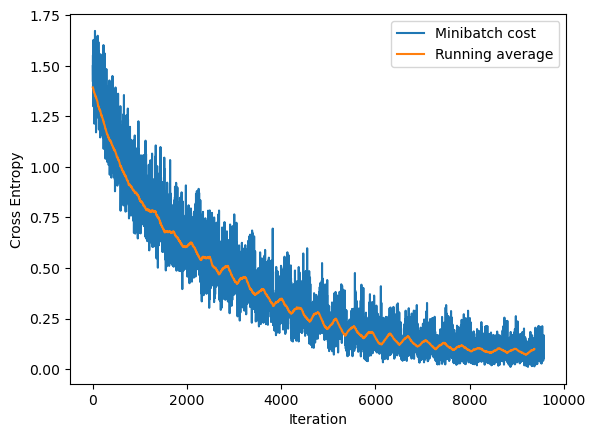

In [40]:
plt.plot(cost_list, label='Minibatch cost')
plt.plot(np.convolve(cost_list, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

In [60]:
train_list =[]
valid_list = []
for i in train_acc_list:
    train_list.append(i.item()) 

for k in valid_acc_list:
    valid_list.append(k.item())
    

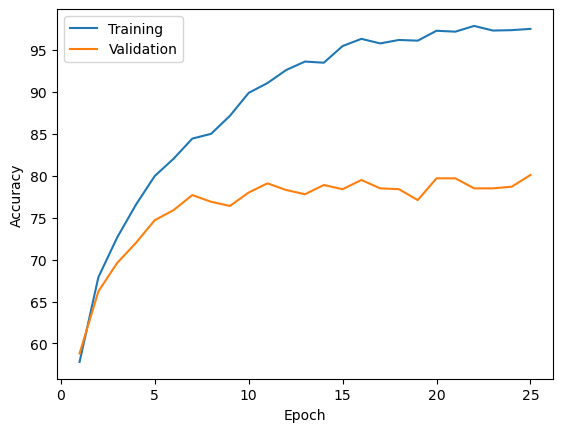

In [62]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_list, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_list, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

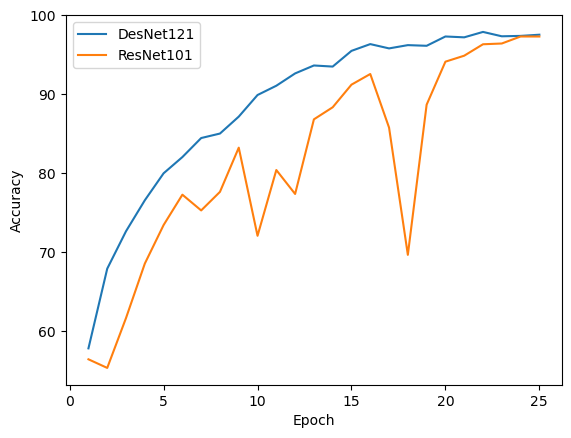

In [64]:
#eval Resnet101 vs Desnet121 training accuracy
plt.plot(np.arange(1, NUM_EPOCHS+1), train_list, label='DesNet121')
plt.plot(np.arange(1, NUM_EPOCHS+1), train_ac, label='ResNet101')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

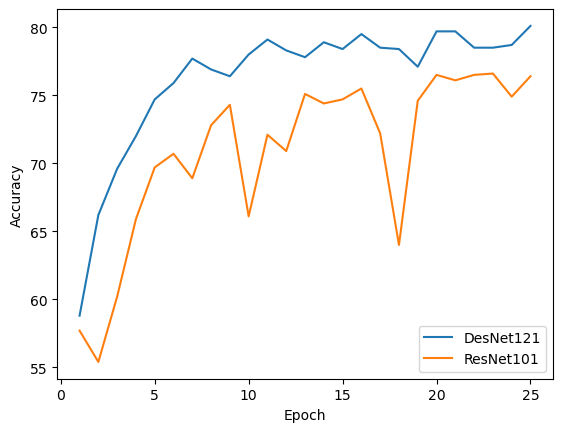

In [65]:
#eval Resnet101 vs Desnet121 validation accuracy
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_list, label='DesNet121')
plt.plot(np.arange(1, NUM_EPOCHS+1), val_ac, label='ResNet101')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


References

[1] He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778). (CVPR Link)

[2] Huang, G., Liu, Z., Van Der Maaten, L., & Weinberger, K. Q. (2017). Densely connected convolutional networks. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 4700-4708), http://openaccess.thecvf.com/content_cvpr_2017/html/Huang_Densely_Connected_Convolutional_CVPR_2017_paper.html

[3] Zhang, K., Tan, L., Li, Z., & Qiao, Y. (2016). Gender and smile classification using deep convolutional neural networks. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition Workshops (pp. 34-38).

